In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import jarque_bera, chi2_contingency
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score, accuracy_score, classification_report, precision_recall_fscore_support, roc_curve, roc_auc_score
from sklearn.calibration import calibration_curve


In [6]:
data = pd.read_csv('cr_loan2.xls')

data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [7]:
data.shape

(32581, 12)

In [8]:
data.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object

In [9]:
data.dtypes.value_counts()

int64      5
object     4
float64    3
dtype: int64

In [10]:
data.drop_duplicates(inplace=True)

data.shape

(32416, 12)

In [11]:
# Univariate analysis

data.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              887
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3095
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [12]:
# Dealing with missing data

data = data.drop(data[data['loan_int_rate'].isna()].index)

data['person_emp_length'].fillna((data['person_emp_length'].median()), inplace=True)

data.shape

(29321, 12)

In [13]:
data.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,29321.000000,2.932100e+04,29321.000000,29321.000000,29321.000000,29321.000000,29321.000000,29321.00000
mean,27.726544,6.602976e+04,4.768050,9587.635142,11.017265,0.219911,0.170141,5.79513
std,6.306105,6.192304e+04,4.100983,6316.319639,3.241680,0.414193,0.106900,4.03579
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.00000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.00000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.00000
75%,30.000000,7.910000e+04,7.000000,12250.000000,13.470000,0.000000,0.230000,8.00000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.00000


In [14]:
data.describe(include='object')

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
count,29321,29321,29321,29321
unique,4,6,7,2
top,RENT,EDUCATION,A,N
freq,14838,5820,9713,24122


In [15]:
object_columns = data.select_dtypes(include=['object'])

for col in object_columns:
    print(data[col].value_counts())
    print("=================================")

RENT        14838
MORTGAGE    12054
OWN          2336
OTHER          93
Name: person_home_ownership, dtype: int64
EDUCATION            5820
MEDICAL              5426
VENTURE              5119
PERSONAL             4994
DEBTCONSOLIDATION    4683
HOMEIMPROVEMENT      3279
Name: loan_intent, dtype: int64
A    9713
B    9337
C    5809
D    3309
E     880
F     214
G      59
Name: loan_grade, dtype: int64
N    24122
Y     5199
Name: cb_person_default_on_file, dtype: int64


0    0.780089
1    0.219911
Name: loan_status, dtype: float64

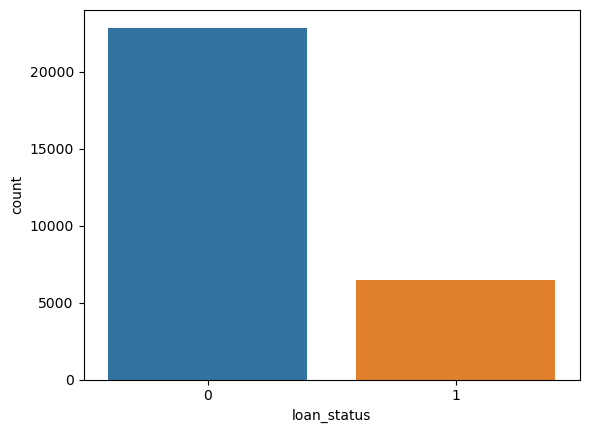

In [16]:
sns.countplot(x=data['loan_status'])

data['loan_status'].value_counts() / data.shape[0]

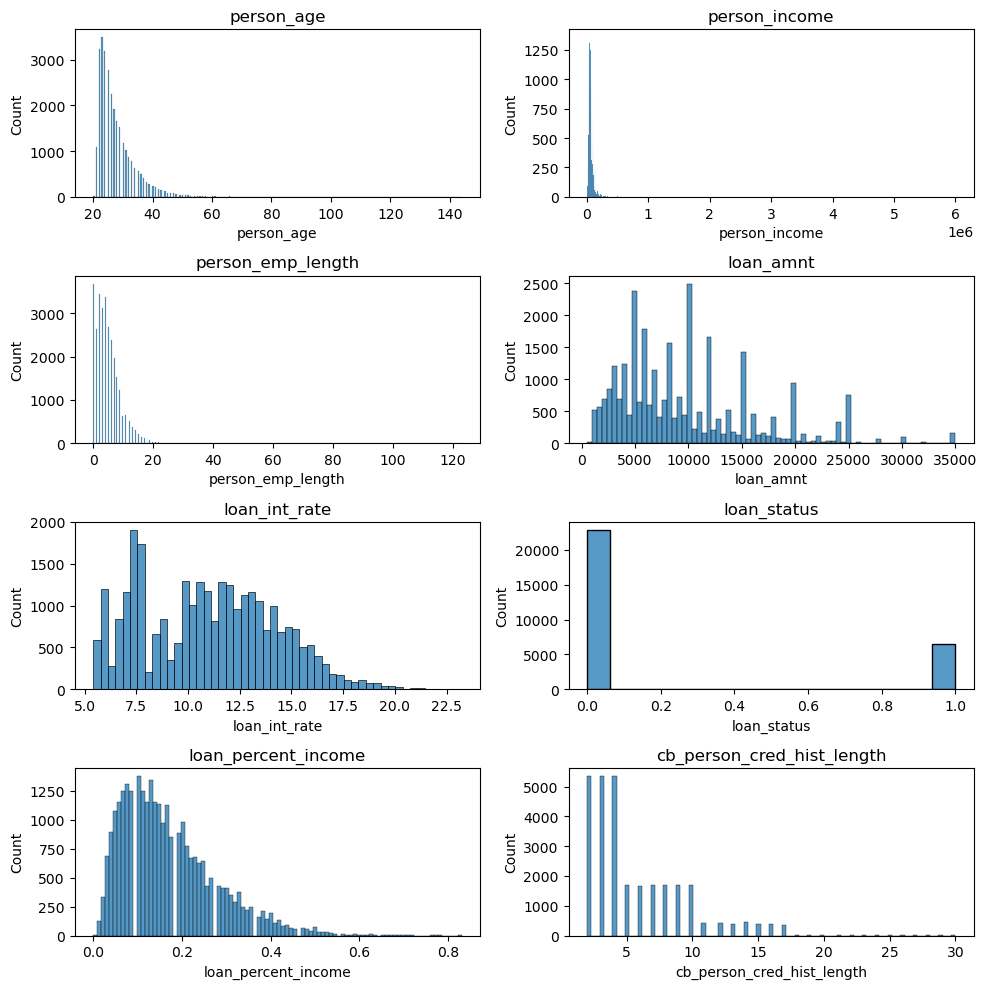

In [17]:
num_columns = data.select_dtypes(exclude=['object'])
columns = num_columns.columns
fig, axs = plt.subplots(4, 2, figsize=(10, 10))
sns.histplot(num_columns.iloc[:,0],ax=axs[0, 0]).set_title(columns[0])
sns.histplot(num_columns.iloc[:,1],ax=axs[0, 1]).set_title(columns[1])
sns.histplot(num_columns.iloc[:,2],ax=axs[1, 0]).set_title(columns[2])
sns.histplot(num_columns.iloc[:,3],ax=axs[1, 1]).set_title(columns[3])
sns.histplot(num_columns.iloc[:,4],ax=axs[2, 0]).set_title(columns[4])
sns.histplot(num_columns.iloc[:,5],ax=axs[2, 1]).set_title(columns[5])
sns.histplot(num_columns.iloc[:,6],ax=axs[3, 0]).set_title(columns[6])
sns.histplot(num_columns.iloc[:,7],ax=axs[3, 1]).set_title(columns[7])
fig.tight_layout()

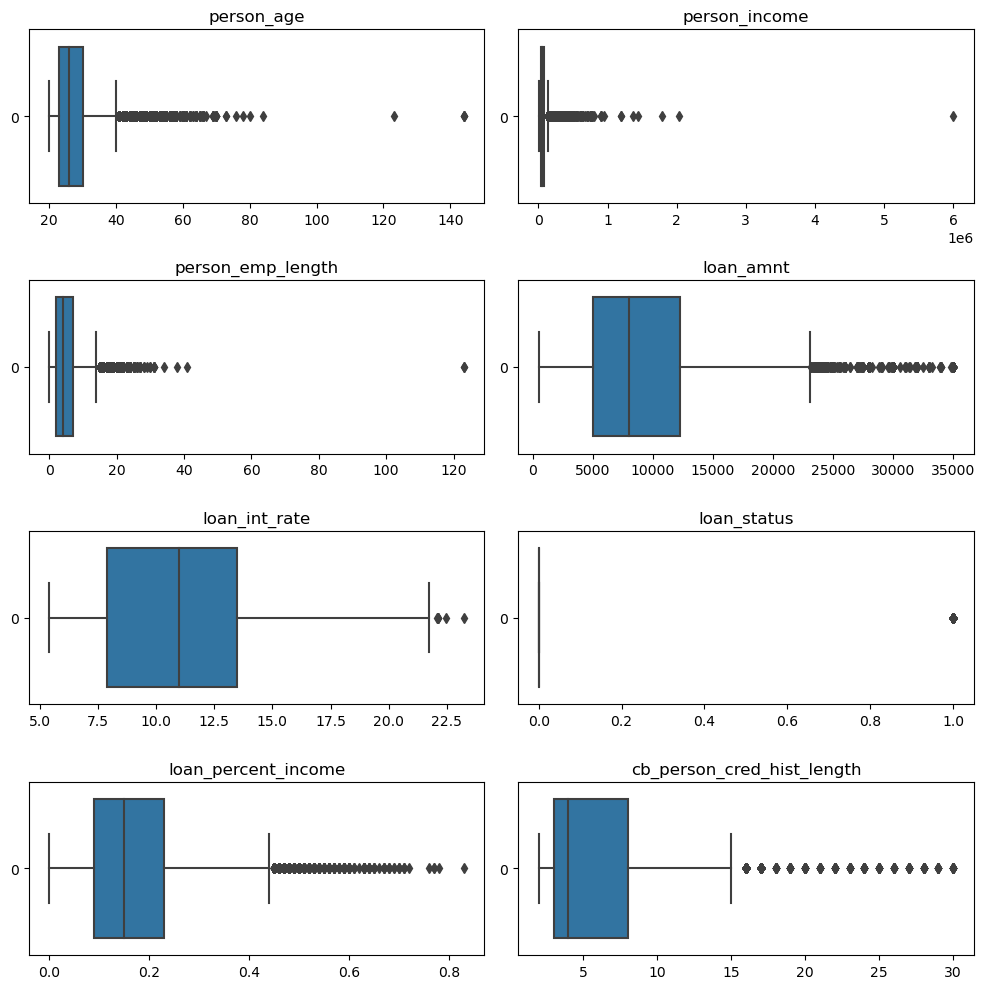

In [18]:
fig, axs = plt.subplots(4, 2, figsize=(10, 10))
sns.boxplot(num_columns.iloc[:,0],ax=axs[0, 0],orient='h').set_title(columns[0])
sns.boxplot(num_columns.iloc[:,1],ax=axs[0, 1],orient='h').set_title(columns[1])
sns.boxplot(num_columns.iloc[:,2],ax=axs[1, 0],orient='h').set_title(columns[2])
sns.boxplot(num_columns.iloc[:,3],ax=axs[1, 1],orient='h').set_title(columns[3])
sns.boxplot(num_columns.iloc[:,4],ax=axs[2, 0],orient='h').set_title(columns[4])
sns.boxplot(num_columns.iloc[:,5],ax=axs[2, 1],orient='h').set_title(columns[5])
sns.boxplot(num_columns.iloc[:,6],ax=axs[3, 0],orient='h').set_title(columns[6])
sns.boxplot(num_columns.iloc[:,7],ax=axs[3, 1],orient='h').set_title(columns[7])
fig.tight_layout()

In [19]:
# Removing anomalies 

data = data.drop(data[data['person_emp_length'] > 60].index)

data = data.drop(data[data['person_age'] > 100].index)

data.shape

(29315, 12)

0    0.780078
1    0.219922
Name: loan_status, dtype: float64

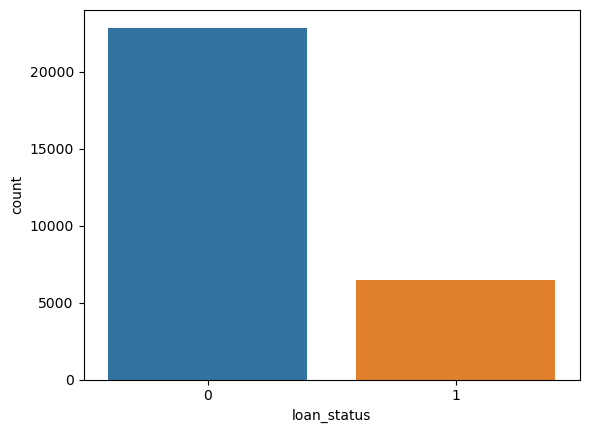

In [20]:
sns.countplot(x=data['loan_status'])

data['loan_status'].value_counts() / data.shape[0]

In [21]:
data.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,29315.000000,2.931500e+04,29315.000000,29315.000000,29315.000000,29315.000000,29315.000000,29315.000000
mean,27.711820,6.581196e+04,4.759884,9586.486440,11.017099,0.219922,0.170142,5.794951
std,6.170817,5.129993e+04,3.983167,6314.459818,3.241718,0.414200,0.106870,4.034470
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.905000e+04,7.000000,12250.000000,13.470000,0.000000,0.230000,8.000000
max,84.000000,2.039784e+06,41.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [22]:
def kde_loan_status(var_name, df, ax):
    
    corr = df['loan_status'].corr(df[var_name])
    med_repaid = df.loc[df['loan_status'] == 0, var_name].median()
    med_not_repaid = df.loc[df['loan_status'] == 1, var_name].median()
    skew_repaid = df.loc[df['loan_status'] == 0, var_name].skew()
    skew_not_repaid = df.loc[df['loan_status'] == 1, var_name].skew()
    kurt_repaid = df.loc[df['loan_status'] == 0, var_name].kurt()
    kurt_not_repaid = df.loc[df['loan_status'] == 1, var_name].kurt()
    test_statistic_repaid, p_value_repaid = jarque_bera(df.loc[df['loan_status'] == 0, var_name])
    test_statistic_not_repaid, p_value_not_repaid = jarque_bera(df.loc[df['loan_status'] == 1, var_name])
    
    plt.figure(figsize=(12, 6))

    sns.kdeplot(df.loc[df['loan_status'] == 0, var_name], label='loan_status == 0', ax=ax)
    sns.kdeplot(df.loc[df['loan_status'] == 1, var_name], label='loan_status == 1', ax=ax)
    
    ax.set_xlabel(var_name)
    ax.set_ylabel('Density')
    ax.set_title('%s density' % var_name)
    ax.legend()

    BOLD = '\033[1m'
    RESET = '\033[0m'

    print(f"{BOLD}{var_name}{RESET}")
    print('Correlation between %s and the target variable is %0.4f' % (var_name, corr))
    print('Median for loans that were not repaid = %0.4f' % med_not_repaid)
    print('Median for loans that were repaid = %0.4f' % med_repaid)
    print('Skewness for loans that were not repaid = %0.4f' % skew_not_repaid)
    print('Skewness for loans that were repaid = %0.4f' % skew_repaid)
    print('Kurtosis for loans that were not repaid = %0.4f' % kurt_not_repaid)
    print('Kurtosis for loans that were repaid = %0.4f' % kurt_repaid)
    print('Jarque-Bera test statistic for loans that were not repaid = %0.4f' % test_statistic_not_repaid)
    print('p-value for loans that were not repaid = %0.4f' % p_value_not_repaid)
    print('Jarque-Bera test statistic for loans that were repaid = %0.4f' % test_statistic_repaid)
    print('p-value for loans that were repaid = %0.4f' % p_value_repaid)
    
    if p_value_not_repaid < 0.05:
        print(f"Distribution of {var_name} for loans that were not repaid does not follow a normal distribution")
    else:
        print(f"Distribution of {var_name} for loans that were not repaid follows a normal distribution")

    if p_value_repaid < 0.05:
        print(f"Distribution of {var_name} for loans that were repaid does not follow a normal distribution")
    else:
        print(f"Distribution of {var_name} for loans that were repaid follows a normal distribution")

    print('------------------------------------------------------------------------------------')

person_age
Correlation between person_age and the target variable is -0.0218
Median for loans that were not repaid = 26.0000
Median for loans that were repaid = 26.0000
Skewness for loans that were not repaid = 1.9916
Skewness for loans that were repaid = 1.8958
Kurtosis for loans that were not repaid = 5.6487
Kurtosis for loans that were repaid = 5.5402
Jarque-Bera test statistic for loans that were not repaid = 12815.2561
p-value for loans that were not repaid = 0.0000
Jarque-Bera test statistic for loans that were repaid = 42927.0087
p-value for loans that were repaid = 0.0000
Distribution of person_age for loans that were not repaid does not follow a normal distribution
Distribution of person_age for loans that were repaid does not follow a normal distribution
------------------------------------------------------------------------------------
person_income
Correlation between person_income and the target variable is -0.1722
Median for loans that were not repaid = 42000.0000
Median

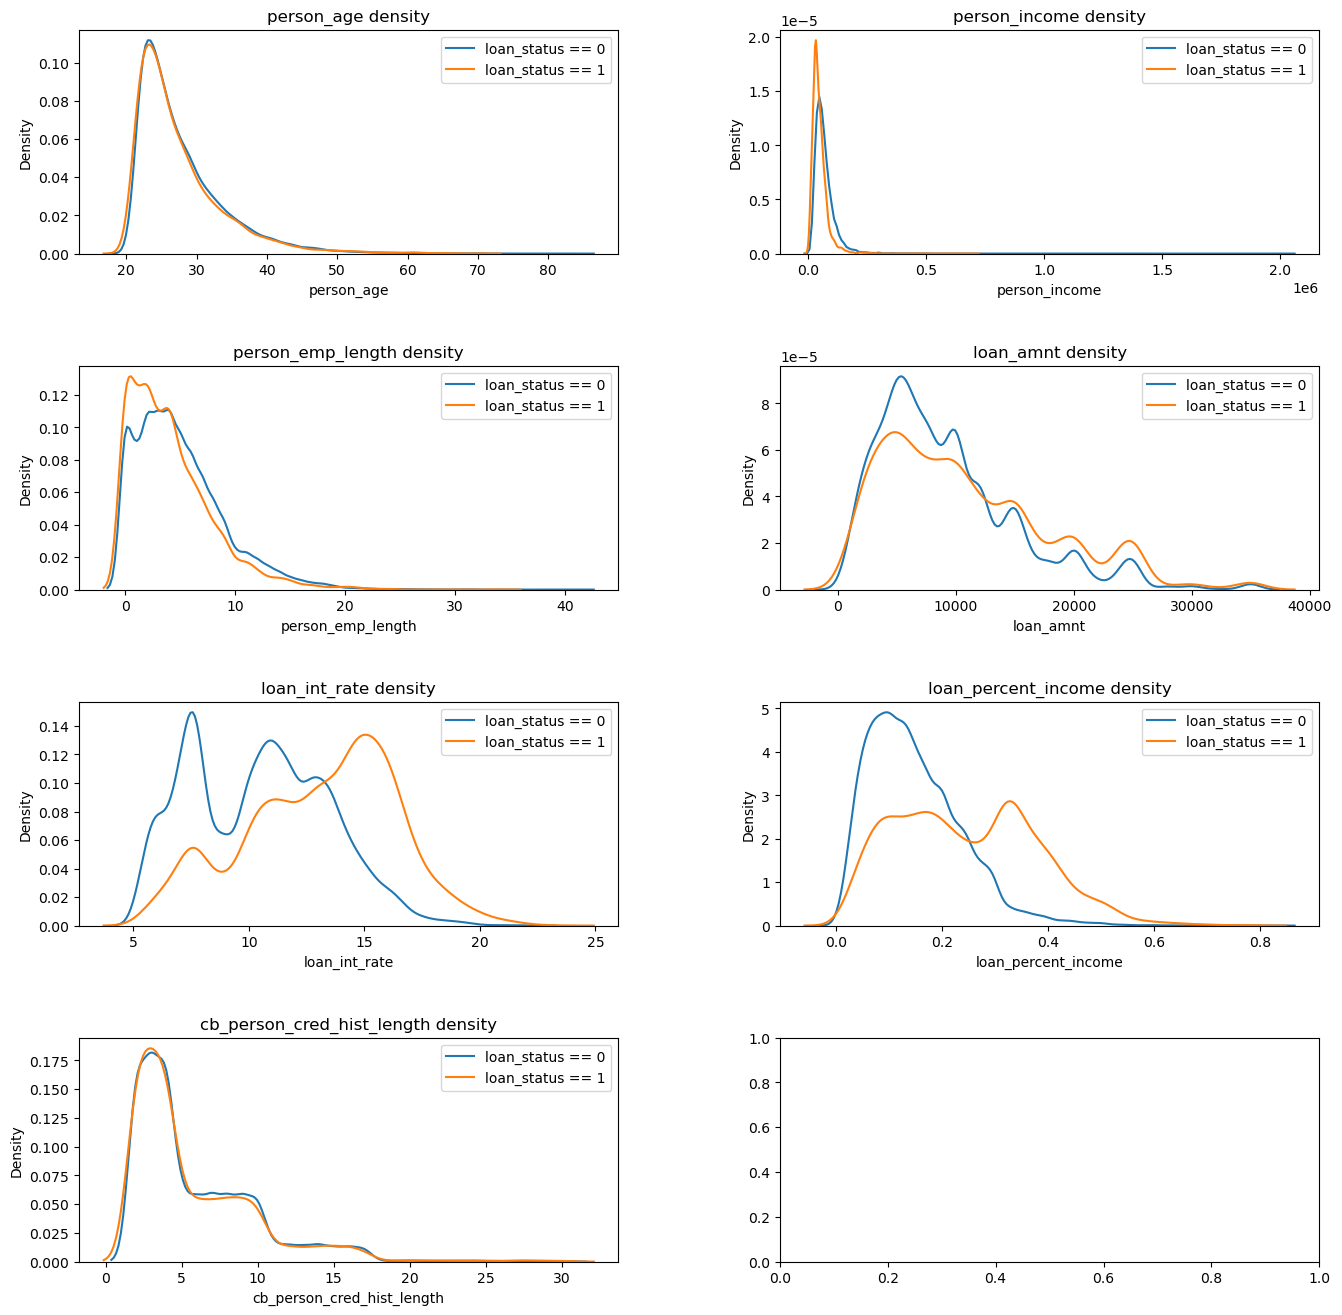

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [23]:
fig, axs = plt.subplots(4, 2, figsize=(16, 16))
plt.subplots_adjust(hspace=0.5, wspace=0.3)
variables_to_plot = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']  

for i, var in enumerate(variables_to_plot):
    row = i // 2
    col = i % 2
    kde_loan_status(var, data, ax=axs[row, col])

plt.tight_layout()
plt.show()


In [24]:
data.describe(include='object')

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
count,29315,29315,29315,29315
unique,4,6,7,2
top,RENT,EDUCATION,A,N
freq,14835,5818,9712,24117


In [25]:
def cat_variables_loan_status(var_name, hue, df, ax):
    sns.countplot(x=var_name, hue=hue, data=df, ax=ax)
    ax.set_xlabel(var_name)
    ax.set_ylabel('Count')
    ax.set_title('%s distribution' % var_name)
    ax.tick_params(axis='x', labelsize=7)

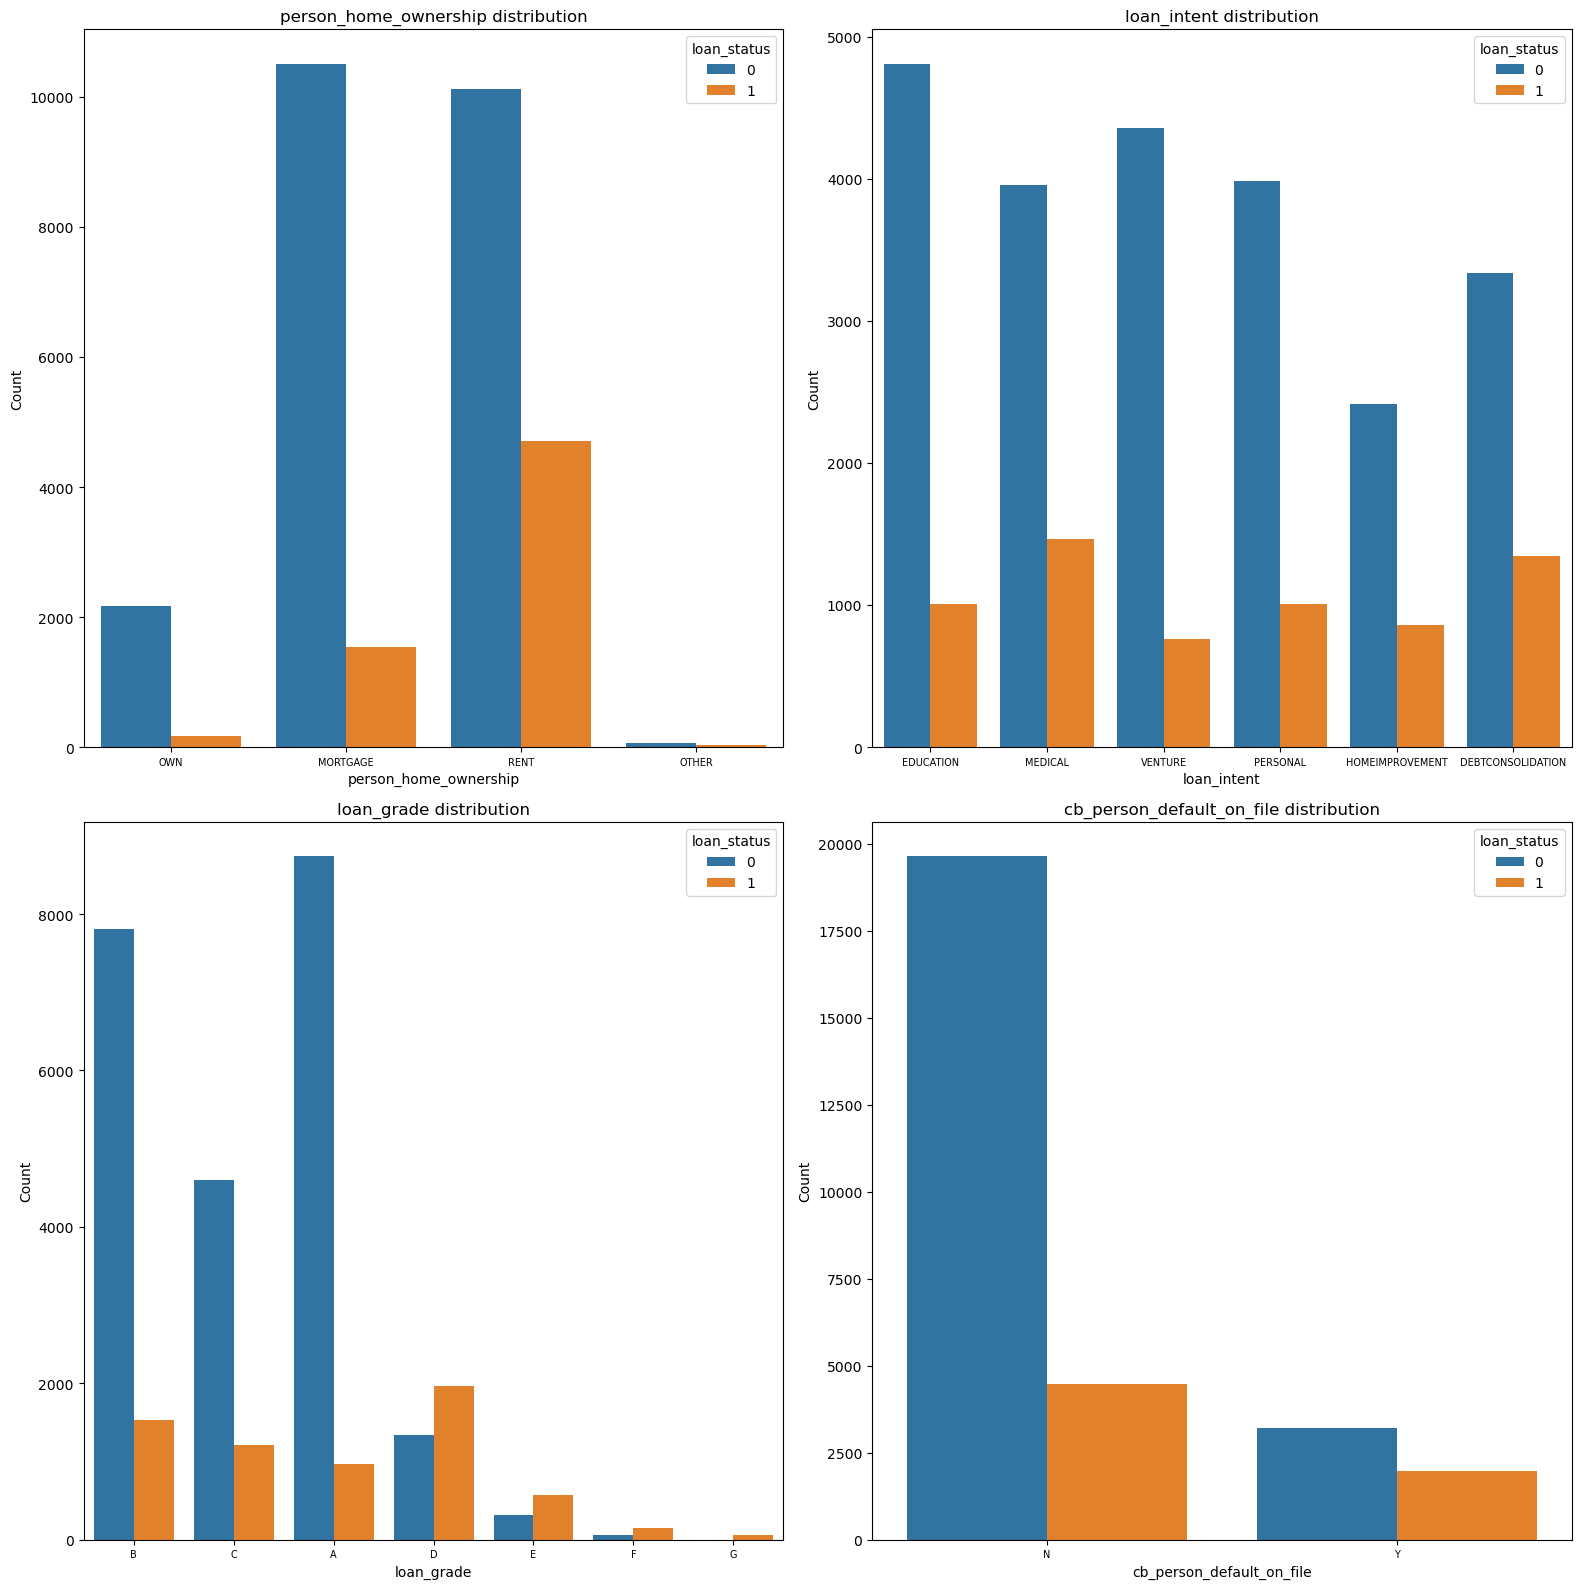

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(16, 16))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

categorical_variables_to_plot = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']  

for i, var in enumerate(categorical_variables_to_plot):
    row = i // 2
    col = i % 2
    cat_variables_loan_status(var, 'loan_status', data, ax=axs[row, col])

plt.tight_layout()
plt.show()

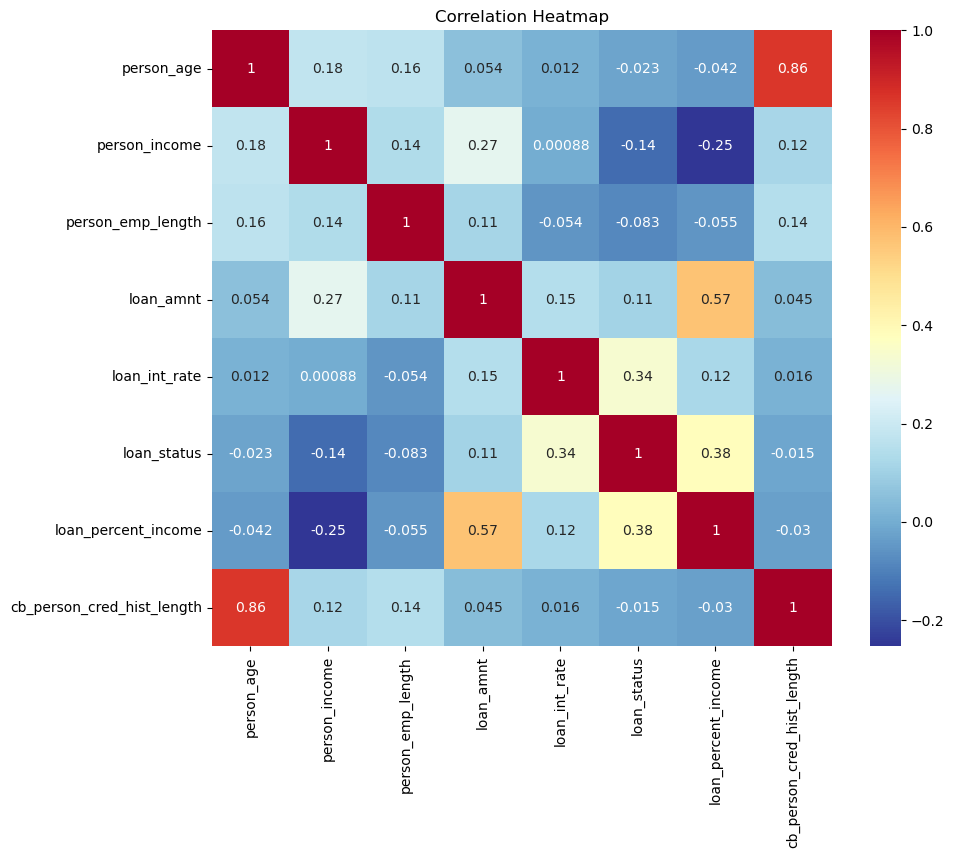

In [27]:
# Bivariate analysis - numerical variables

plt.figure(figsize=(10,8))
corr = num_columns.corr()
sns.heatmap(corr, cmap = plt.cm.RdYlBu_r, annot = True)
plt.title('Correlation Heatmap');

In [28]:
data.drop('cb_person_cred_hist_length', axis=1, inplace=True)

/var/folders/cb/rfcndmvn0v94zv5yyvyjkn780000gn/T/ipykernel_1356/3618712675.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  object_columns_with_target['loan_status'] = object_columns_with_target['loan_status'].map({0:'No',1:'Yes'}).astype('category')


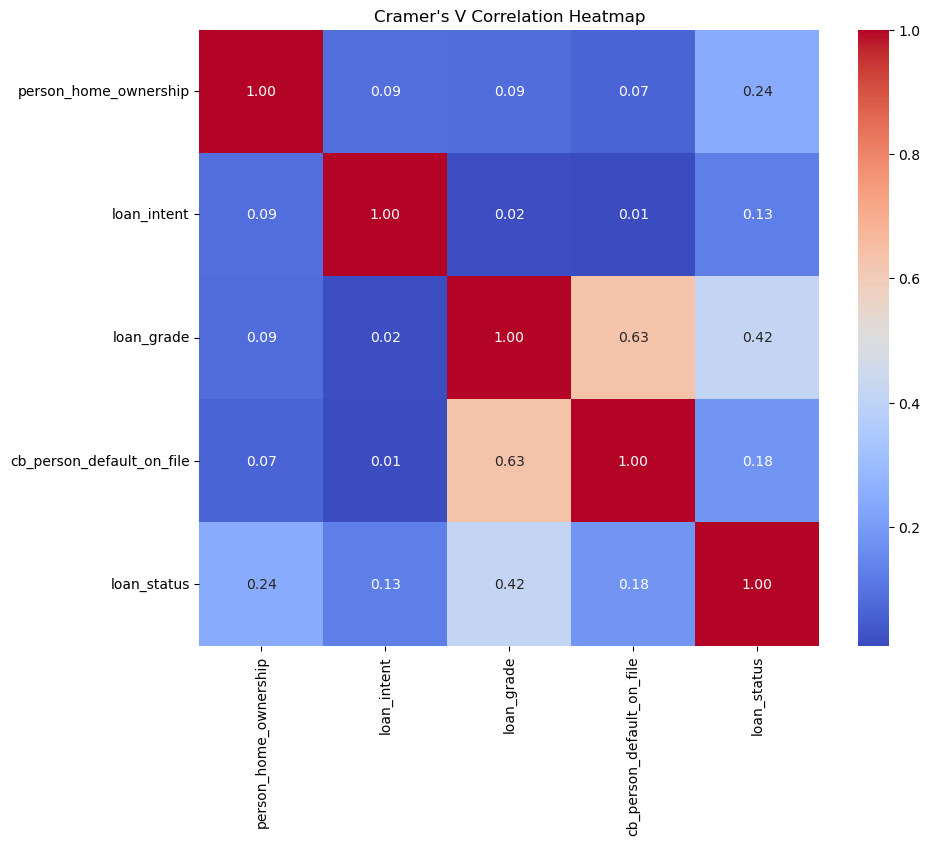

In [29]:
# Bivariate analysis - categorical variables 

object_columns_with_target = data[['person_home_ownership','loan_intent','loan_grade','cb_person_default_on_file', 'loan_status']]
object_columns_with_target['loan_status'] = object_columns_with_target['loan_status'].map({0:'No',1:'Yes'}).astype('category')

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

cramer_v_matrix = pd.DataFrame(index=object_columns_with_target.columns, columns=object_columns_with_target.columns)
for i, col1 in enumerate(object_columns_with_target.columns):
    for j, col2 in enumerate(object_columns_with_target.columns):
            confusion_matrix = pd.crosstab(object_columns_with_target[col1], object_columns_with_target[col2])
            cramer_v_matrix.loc[col1, col2] = cramers_v(confusion_matrix)
            
plt.figure(figsize=(10, 8))
sns.heatmap(cramer_v_matrix.astype(float), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Cramer's V Correlation Heatmap")
plt.show()

In [30]:
# One-hot encoding of categorical variables

data.reset_index(drop=True, inplace=True)

num = data.select_dtypes(exclude=['object'])
obj = data.select_dtypes(include=['object'])

columns_onehot = pd.get_dummies(obj)
dataset = pd.concat([num, columns_onehot], axis=1)

In [31]:
# Split into training and test sets

X = dataset.drop('loan_status', axis=1)
y = dataset['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=1)


In [42]:
# Optimal models selection with grid search using undersampled training set

X_y_train = pd.concat([X_train.reset_index(drop = True),
                       y_train.reset_index(drop = True)], axis = 1)
count_nondefault, count_default = X_y_train['loan_status'].value_counts()

nondefaults = X_y_train[X_y_train['loan_status'] == 0]
defaults = X_y_train[X_y_train['loan_status'] == 1]

nondefaults_under = nondefaults.sample(count_default, random_state=42)

X_y_train_under = pd.concat([nondefaults_under.reset_index(drop = True),
                             defaults.reset_index(drop = True)], axis = 0)

X_train_under = X_y_train_under.drop('loan_status', axis=1)
y_train_under = X_y_train_under['loan_status']

np.random.seed(42)

models = {
    "SVC": SVC(random_state=42),
    "GaussianNB": GaussianNB(),
    "SGDClassifier": SGDClassifier(random_state=42),
    "NeuralNetwork": MLPClassifier(random_state=42),
    }

param_grid = {
    "SVC": {'C': [0.001, 1, 10]},
    "GaussianNB": {},
    "SGDClassifier": {'alpha': [0.0001, 0.001, 0.01]},
    "NeuralNetwork": {'hidden_layer_sizes': [(50,), (100,), (50, 50)], 'activation': ['relu', 'tanh']},
    }

f1_scorer = make_scorer(f1_score)

for name, classifier in models.items():
    print(f"Grid Search for {name}")
    tuning_under = GridSearchCV(classifier, param_grid[name], cv=3, scoring=f1_scorer, n_jobs=-1, verbose=0)
    tuning_under.fit(X_train_under, y_train_under)
    print(f"Best parameters: {tuning_under.best_params_}")
    print(f"F1-score on undersampled training set: " "{:.2f}".format(tuning_under.best_score_))

    train_pred_under = tuning_under.predict(X_train_under)
    train_accuracy_under = accuracy_score(y_train_under, train_pred_under)
    print(f"Accuracy on undersampled training set: %.2f" % train_accuracy_under)

    test_pred_under = tuning_under.predict(X_test)
    test_accuracy_under = accuracy_score(y_test, test_pred_under)
    print(f"Accuracy on test set: %.2f" % test_accuracy_under)

    f1_under = f1_score(y_test, test_pred_under)
    print(f"F1-score on test set: %.2f" % f1_under)

    print('------------------------------------------------------------')

Grid Search for SVC
Best parameters: {'C': 1}
F1-score on undersampled training set: 0.68
Accuracy on undersampled training set: 0.70
Accuracy on test set: 0.75
F1-score on test set: 0.52
------------------------------------------------------------
Grid Search for GaussianNB
Best parameters: {}
F1-score on undersampled training set: 0.71
Accuracy on undersampled training set: 0.70
Accuracy on test set: 0.66
F1-score on test set: 0.50
------------------------------------------------------------
Grid Search for SGDClassifier
Best parameters: {'alpha': 0.01}
F1-score on undersampled training set: 0.67
Accuracy on undersampled training set: 0.68
Accuracy on test set: 0.75
F1-score on test set: 0.47
------------------------------------------------------------
Grid Search for NeuralNetwork
Best parameters: {'activation': 'relu', 'hidden_layer_sizes': (50,)}
F1-score on undersampled training set: 0.67
Accuracy on undersampled training set: 0.66
Accuracy on test set: 0.82
F1-score on test set:

In [43]:
# Optimal models selection with grid search using the entire training set

np.random.seed(42)

for name, classifier in models.items():
    print(f"Grid Search for {name}")
    tuning = GridSearchCV(classifier, param_grid[name], cv=3, scoring=f1_scorer, n_jobs=-1, verbose=0)
    tuning.fit(X_train, y_train)
    print(f"Best parameters: {tuning.best_params_}")
    print(f"F1-score on the entire training set: " "{:.2f}".format(tuning.best_score_))

    train_pred = tuning.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_pred)
    print(f"Accuracy on the entire training set: %.2f" % train_accuracy)

    test_pred = tuning.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_pred)
    print(f"Accuracy on test set: %.2f" % test_accuracy)

    f1 = f1_score(y_test, test_pred)
    print(f"F1-score on test set: %.2f" % f1)

    print('------------------------------------------------------------')

Grid Search for SVC
Best parameters: {'C': 10}
F1-score on the entire training set: 0.37
Accuracy on the entire training set: 0.82
Accuracy on test set: 0.82
F1-score on test set: 0.38
------------------------------------------------------------
Grid Search for GaussianNB
Best parameters: {}
F1-score on the entire training set: 0.42
Accuracy on the entire training set: 0.82
Accuracy on test set: 0.82
F1-score on test set: 0.44
------------------------------------------------------------
Grid Search for SGDClassifier
Best parameters: {'alpha': 0.0001}
F1-score on the entire training set: 0.45
Accuracy on the entire training set: 0.83
Accuracy on test set: 0.83
F1-score on test set: 0.46
------------------------------------------------------------
Grid Search for NeuralNetwork
Best parameters: {'activation': 'tanh', 'hidden_layer_sizes': (50, 50)}
F1-score on the entire training set: 0.50
Accuracy on the entire training set: 0.83
Accuracy on test set: 0.83
F1-score on test set: 0.46
----

In [ ]:
#Since none of the tuned alternative classification models has reached a satisfactory F1-score on both training and test sets (in comparison with traditional models),
#another grid search using Random Forest Classifier will be performed 

In [46]:
#Optimal Random Forest Classifier selection with grid search using undersampled training set

np.random.seed(42)

grid = {
    'n_estimators': [50, 100, 200],
    'max_features': np.linspace(1, X_train.shape[1], 3).astype(int)
}

tuning_rf_under = GridSearchCV(RandomForestClassifier(random_state=42),
                             param_grid=grid,
                             scoring=f1_scorer,
                             n_jobs=1,
                             cv=3,
                             verbose=0)

tuning_rf_under.fit(X_train_under, y_train_under)

print("Grid Search for RandomForestClassifier")
print(f"Best parameters: {tuning_rf_under.best_params_}")
print(f"F1-score on the undersampled training set: " "{:.2f}".format(tuning_rf_under.best_score_))

train_pred_rf_under = tuning_rf_under.predict(X_train_under)
train_accuracy_rf_under = accuracy_score(y_train_under, train_pred_rf_under)
print(f"Accuracy on the undersampled training set: %.2f" % train_accuracy_rf_under)

test_pred_rf_under = tuning_rf_under.predict(X_test)
test_accuracy_rf_under = accuracy_score(y_test, test_pred_rf_under)
print(f"Accuracy on test set: %.2f" % test_accuracy_rf_under)

f1_rf_under = f1_score(y_test, test_pred_rf_under)
print(f"F1-score on test set: %.2f" % f1_rf_under)

Grid Search for RandomForestClassifier
Best parameters: {'max_features': 13, 'n_estimators': 200}
F1-score on the undersampled training set: 0.85
Accuracy on the undersampled training set: 1.00
Accuracy on test set: 0.90
F1-score on test set: 0.77


Grid Search for RandomForestClassifier
Best parameters: {'max_features': 13, 'n_estimators': 200}
F1-score on the entire training set: 0.83
Accuracy on the entire training set: 1.00
Accuracy on test set: 0.93
F1-score on test set: 0.83


Text(50.722222222222214, 0.5, 'Number of features')

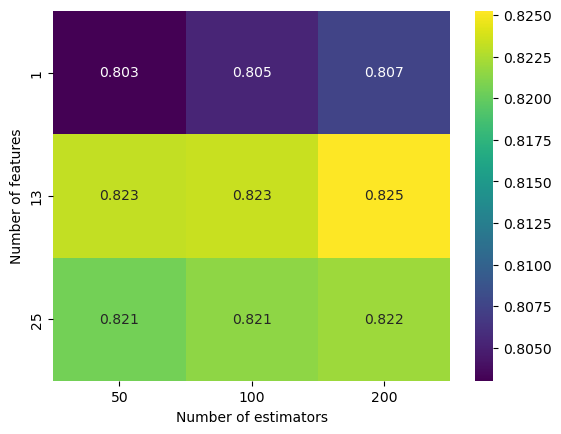

In [48]:
#Optimal Random Forest Classifier selection with grid search using the entire training set

np.random.seed(42)

tuning_rf = GridSearchCV(RandomForestClassifier(random_state=42),
                             param_grid=grid,
                             scoring=f1_scorer,
                             n_jobs=1,
                             cv=3,
                             verbose=0)

tuning_rf.fit(X_train, y_train)

print("Grid Search for RandomForestClassifier")
print(f"Best parameters: {tuning_rf.best_params_}")
print(f"F1-score on the entire training set: " "{:.2f}".format(tuning_rf.best_score_))

train_pred_rf = tuning_rf.predict(X_train)
train_accuracy_rf = accuracy_score(y_train, train_pred_rf)
print(f"Accuracy on the entire training set: %.2f" % train_accuracy_rf)

test_pred_rf = tuning_rf.predict(X_test)
test_accuracy_rf = accuracy_score(y_test, test_pred_rf)
print(f"Accuracy on test set: %.2f" % test_accuracy_rf)

f1_rf = f1_score(y_test, test_pred_rf)
print(f"F1-score on test set: %.2f" % f1_rf)

n_trees = grid['n_estimators']
max_features = grid['max_features']
arr = tuning_rf.cv_results_['mean_test_score'].reshape(
    len(max_features), len(n_trees))
df = pd.DataFrame(arr, columns=n_trees, index=max_features)

p = sns.heatmap(df, annot=True, fmt='.3f', cmap='viridis')
p.set_xlabel("Number of estimators")
p.set_ylabel("Number of features")

0    4902
1     961
Name: loan_status, dtype: int64
              precision    recall  f1-score   support

 Non-Default       0.93      0.99      0.96      4570
     Default       0.97      0.72      0.83      1293

    accuracy                           0.93      5863
   macro avg       0.95      0.86      0.89      5863
weighted avg       0.94      0.93      0.93      5863

---------------------------------------------------------------------------------


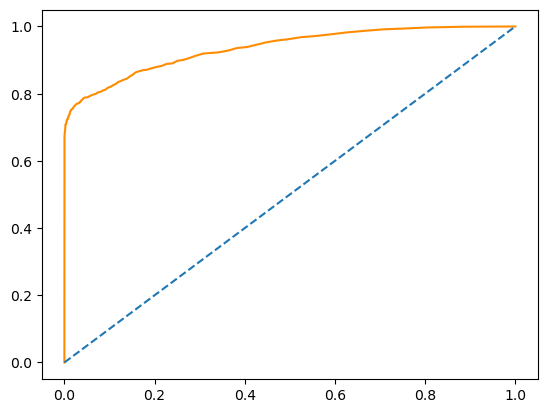

AUC: 0.94


/Users/wiktoriaceniuk/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wiktoriaceniuk/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


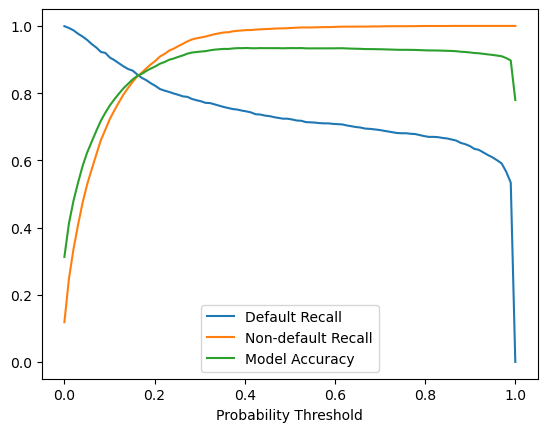

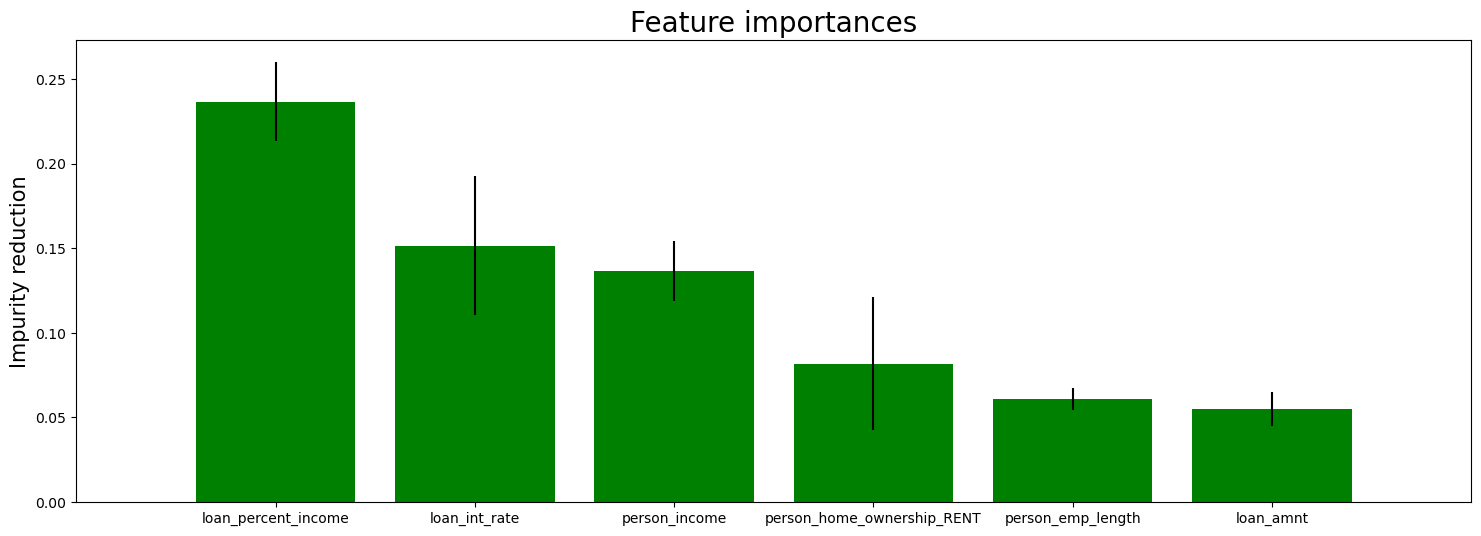

In [54]:
# Best model performance analysis


prediction = pd.DataFrame(test_pred_rf, columns=['loan_status'])
print(prediction['loan_status'].value_counts())
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, prediction['loan_status'], target_names=target_names))
print('---------------------------------------------------------------------------------')

inter_threshold = []

predictions_proba_test = tuning_rf.best_estimator_.predict_proba(X_test)
prob_default = predictions_proba_test[:, 1]
fallout, sensitivity, thresholds = roc_curve(y_test, prob_default)
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()
auc = roc_auc_score(y_test, prob_default)
print(f"AUC: {auc :.2f}")
predictions_proba_test_df = pd.DataFrame(predictions_proba_test[:, 1], columns=['prob_default'])
thresholds = np.linspace(0, 1, 100)
default_recalls = []
non_default_recalls = []
accuracies = []
for thresh in thresholds:
    predictions_proba_test_df['loan_status'] = predictions_proba_test_df['prob_default'].apply(lambda x: 1 if x > thresh else 0)
    default_recall = precision_recall_fscore_support(y_test, predictions_proba_test_df['loan_status'])[1][1]
    non_default_recall = precision_recall_fscore_support(y_test, predictions_proba_test_df['loan_status'])[1][0]
    accuracy = accuracy_score(y_test, predictions_proba_test_df['loan_status'])
        
    default_recalls.append(default_recall)
    non_default_recalls.append(non_default_recall)
    accuracies.append(accuracy)
        
plt.plot(thresholds,default_recalls)
plt.plot(thresholds,non_default_recalls)
plt.plot(thresholds,accuracies)
plt.xlabel("Probability Threshold")
plt.legend(["Default Recall","Non-default Recall","Model Accuracy"])
plt.show()

min_difference = float('inf')

for i in range(len(thresholds)):
    difference = abs(default_recalls[i] - non_default_recalls[i]) + abs(default_recalls[i] - accuracies[i]) + abs(non_default_recalls[i] - accuracies[i])
    if difference < min_difference:
        min_difference = difference
        intersection_threshold = thresholds[i]

    inter_threshold.append(intersection_threshold)

importances = tuning_rf.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in tuning_rf.best_estimator_.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

num_feat = 6
plt.figure(figsize=[18, 6])
plt.title("Feature importances", fontsize=20)
plt.bar(range(num_feat)[:num_feat],
        importances[indices][:num_feat],
        color="g",
        yerr=std[indices][:num_feat],
        align="center")
plt.xticks(range(num_feat)[:num_feat], X_train.columns[indices[:num_feat]])
plt.xlim([-1, num_feat])
plt.ylabel("Impurity reduction", fontsize=15);

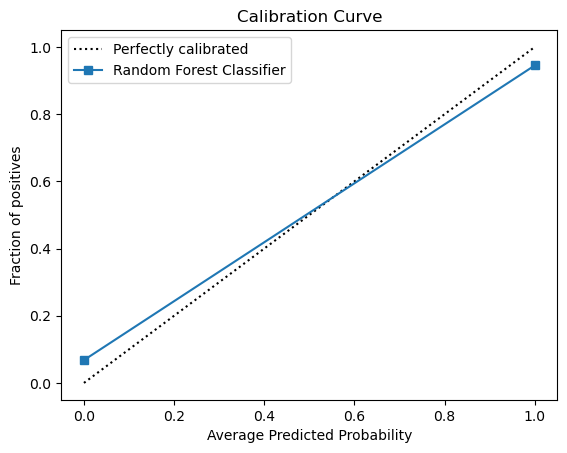

In [58]:
# Calibration curve

predictions_optimal_rf = (tuning_rf.best_estimator_.predict_proba(X_test)[:, 1] > 0.4).astype(int)

frac_of_pos_rf, mean_pred_val_rf = calibration_curve(y_test, predictions_optimal_rf)

plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')    
plt.plot(mean_pred_val_rf, frac_of_pos_rf,
         's-', label='%s' % 'Random Forest Classifier')
plt.ylabel('Fraction of positives')
plt.xlabel('Average Predicted Probability')
plt.legend()
plt.title('Calibration Curve')
plt.show()

    Acceptance Rate  Threshold  Bad Rate  Num Accepted Loans  Avg Loan Amnt  \
0              1.00      1.000     0.062                5863        7934.79   
1              0.95      1.000     0.062                5863        7934.79   
2              0.90      0.995     0.062                5315        7902.96   
3              0.85      0.778     0.062                4983        7947.95   
4              0.80      0.295     0.062                4697        7986.48   
5              0.75      0.212     0.062                4397        8049.71   
6              0.70      0.170     0.062                4134        8042.68   
7              0.65      0.135     0.061                3849        7946.11   
8              0.60      0.110     0.060                3556        7904.17   
9              0.55      0.090     0.060                3264        7892.91   
10             0.50      0.075     0.059                3006        7999.13   
11             0.45      0.060     0.058            

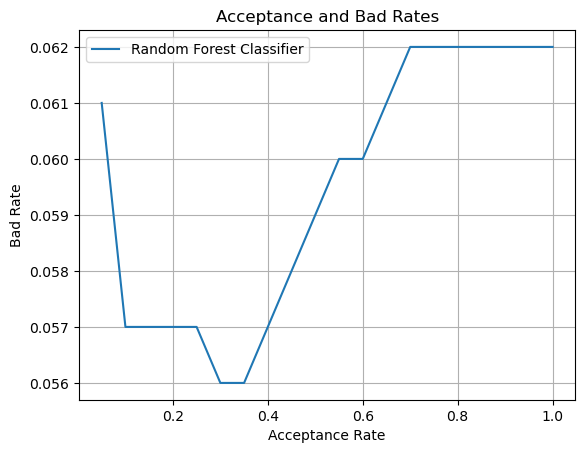

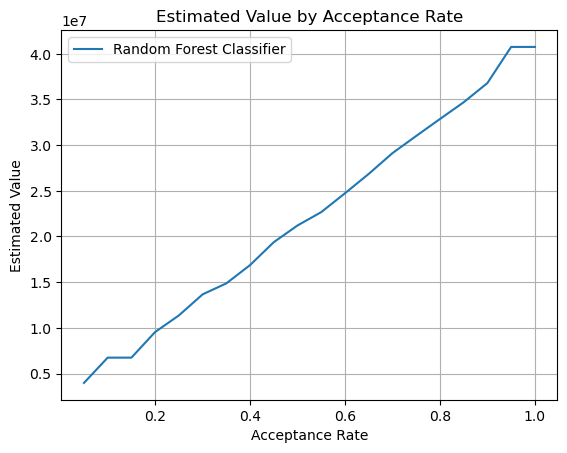

In [59]:
# Strategy table and curve for both models

accept_rates = [round(0.05 * i, 2) for i in range(20, 0, -1)]

thresholds = []
bad_rates = []
num_accepted_loans = []
avg_loan_amnt = []

for rate in accept_rates:
    predictions_proba_test_df = pd.DataFrame(tuning_rf.best_estimator_.predict_proba(X_test)[:, 1], columns=['prob_default'])
    predictions_proba_test_df['true_loan_status'] = y_test
    thresh = np.quantile(predictions_proba_test_df['prob_default'], rate).round(3)
    thresholds.append(thresh)
    predictions_proba_test_df['pred_loan_status'] = predictions_proba_test_df['prob_default'].apply(lambda x: 1 if x > thresh else 0)
    accepted_loans_indices = predictions_proba_test_df[predictions_proba_test_df['pred_loan_status'] == 0].index
    mean_accepted_loan_amount = X_test.loc[X_test.index.isin(accepted_loans_indices), 'loan_amnt'].mean()
    avg_loan_amnt.append(mean_accepted_loan_amount)
    accepted_loans = predictions_proba_test_df[predictions_proba_test_df['pred_loan_status'] == 0]
    num_accepted_loans.append(len(accepted_loans['true_loan_status']))
    bad_rates.append(np.sum((accepted_loans['true_loan_status']) / len(accepted_loans['true_loan_status'])).round(3))


strat = pd.DataFrame(zip(accept_rates, thresholds, bad_rates, num_accepted_loans, avg_loan_amnt),
                        columns = ['Acceptance Rate','Threshold','Bad Rate', 'Num Accepted Loans', 'Avg Loan Amnt'])

strat['Estimated Value'] = ((strat['Num Accepted Loans'] * (1 - strat['Bad Rate'])) * strat['Avg Loan Amnt']) - (strat['Num Accepted Loans'] * strat['Bad Rate'] * strat['Avg Loan Amnt'])

strat['Avg Loan Amnt'] = strat['Avg Loan Amnt'].map('{:.2f}'.format).astype(float)
strat['Estimated Value'] = strat['Estimated Value'].map('{:.2f}'.format).astype(float)

print(strat)

#Strategy curves

plt.plot(strat['Acceptance Rate'], strat['Bad Rate'], label='Random Forest Classifier')
plt.xlabel('Acceptance Rate')
plt.ylabel('Bad Rate')
plt.title('Acceptance and Bad Rates')
plt.grid(True)
plt.legend()
plt.show()

plt.plot(strat['Acceptance Rate'],strat['Estimated Value'], label='Random Forest Classifier')
plt.title('Estimated Value by Acceptance Rate')
plt.xlabel('Acceptance Rate')
plt.ylabel('Estimated Value')
plt.grid(True)
plt.legend()
plt.show()

In [60]:
# Total expected loss

test_df = pd.DataFrame(tuning_rf.best_estimator_.predict_proba(X_test)[:, 1], columns=['PD'])
test_df['LGD'] = 1.0
test_df['EAD'] = X_test['loan_amnt'].reset_index(drop=True)
total_expected_loss = (test_df['PD'] * test_df['LGD'] * test_df['EAD']).sum()

print('Total expected loss for Random Forest Classifier: ', '${:,.2f}'.format(total_expected_loss))

Total expected loss for Random Forest Classifier:  $13,999,754.62
